In [ ]:
# ==========================================================================
# IMPORTS AND SETUP
# ==========================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import LeaveOneGroupOut, GroupKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("="*80)
print("LACROSSE POSSESSION OUTCOME PREDICTION - LOGISTIC REGRESSION")
print("="*80)
print("  All libraries imported successfully")
print(f"  Random state set to {RANDOM_STATE}")

LACROSSE POSSESSION OUTCOME PREDICTION - LOGISTIC REGRESSION
  All libraries imported successfully
  Random state set to 42


In [ ]:
# ==========================================================================
# CONFIGURATION
# ==========================================================================
print("\n" + "="*80)
print("CONFIGURATION")
print("="*80)

# File path
EXCEL_PATH = "/content/Thesis - Tagging1.xlsx"

# Column mapping
COLUMN_MAP = {
    "id_cols": ["possession_id", "game_id"],
    "outcome": "outcome",
    "numeric": [
        "possession_number",
        "period",
        "time_left_period",
        "time_left_shot_clock",
        "score_differential",
        "fast_break",
        "clock_reset_within_10s",
        "num_passes_10s",
    ],
    "categorical": [
        "first_action",
        "start_type",
    ]
}

# Valid categories
FIRST_ACTION_CATS = {"carry", "pass", "dodge"}
START_TYPE_CATS = {"goalie_save", "turnover", "draw"}
OUTCOME_MAP = {"goal": "Goal", "turnover": "Turnover", "save": "Save"}
VALID_OUTCOMES = {"Goal", "Turnover", "Save"}

print("  Configuration loaded")


CONFIGURATION
  Configuration loaded


In [ ]:
# ==========================================================================
# HELPER FUNCTIONS - DATA LOADING AND CLEANING
# ==========================================================================
print("\n" + "="*80)
print("DEFINING HELPER FUNCTIONS - DATA PROCESSING")
print("="*80)

def norm_str(s):
    """Normalize string values."""
    if pd.isna(s):
        return s
    return str(s).strip().lower()

def time_mmss_to_seconds(x):
    """Convert time in MM:SS format to seconds."""
    if pd.isna(x):
        return np.nan
    if isinstance(x, dt.time):
        return x.hour * 60 + x.minute
    if isinstance(x, str):
        parts = x.strip().split(":")
        if len(parts) == 2:
            m, s = int(parts[0]), int(parts[1])
            return m * 60 + s
        if len(parts) == 3:
            h, m, s = int(parts[0]), int(parts[1]), int(parts[2])
            return h * 60 + m
    return float(x)

def load_and_concatenate_games(excel_path):
    """Load Excel file and concatenate all game sheets."""
    print("\n[Loading Excel file]")
    assert os.path.exists(excel_path), f"Excel not found at: {excel_path}"

    xls = pd.ExcelFile(excel_path)
    print(f"  Found {len(xls.sheet_names)} sheets: {xls.sheet_names}")

    frames = []
    for sheet in xls.sheet_names:
        df_sheet = pd.read_excel(excel_path, sheet_name=sheet)
        df_sheet = df_sheet.dropna(how="all")
        df_sheet['game_id'] = sheet
        frames.append(df_sheet)
        print(f"    {sheet}: {len(df_sheet)} possessions")

    raw = pd.concat(frames, ignore_index=True)
    print(f"\n  Total: {len(raw)} possessions across {raw['game_id'].nunique()} games")

    return raw

def clean_data(df, column_map, outcome_map, valid_outcomes,
               first_action_cats, start_type_cats):
    """Clean and standardize the dataset."""
    print("\n[Data Cleaning]")
    df = df.copy()
    outcome_col = column_map["outcome"]

    # Convert time to seconds
    print("  Converting time_left_period to seconds...")
    df["time_left_period"] = df["time_left_period"].apply(time_mmss_to_seconds)

    # Standardize categorical variables
    print("  Standardizing categorical variables...")
    for col in column_map["categorical"]:
        if col in df.columns:
            df[col] = df[col].map(norm_str)

    # Enforce valid categories
    if "first_action" in df.columns:
        df["first_action"] = df["first_action"].apply(
            lambda x: x if x in first_action_cats else ("unknown" if pd.notna(x) else x)
        )

    if "start_type" in df.columns:
        df["start_type"] = df["start_type"].apply(
            lambda x: x if x in start_type_cats else ("unknown" if pd.notna(x) else x)
        )

    # Normalize outcome
    print("  Normalizing outcome variable...")
    df[outcome_col] = df[outcome_col].map(norm_str).map(lambda x: outcome_map.get(x, x))

    # Remove unexpected outcomes
    actual_outcomes = set(df[outcome_col].dropna().unique())
    unexpected = actual_outcomes - valid_outcomes
    if unexpected:
        print(f"  ⚠ Removing {len(df[~df[outcome_col].isin(valid_outcomes)])} rows with unexpected outcomes: {unexpected}")
        df = df[df[outcome_col].isin(valid_outcomes)]

    # Handle missing values
    print("  Handling missing values...")
    feature_cols = column_map["numeric"] + column_map["categorical"]
    feature_cols = [col for col in feature_cols if col in df.columns]

    # Numeric: fill with median
    for col in column_map["numeric"]:
        if col in df.columns:
            missing_count = df[col].isnull().sum()
            if missing_count > 0:
                df[col].fillna(df[col].median(), inplace=True)

    # Categorical: fill with mode
    for col in column_map["categorical"]:
        if col in df.columns:
            missing_count = df[col].isnull().sum()
            if missing_count > 0:
                mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else "unknown"
                df[col].fillna(mode_val, inplace=True)

    print(f"  Data cleaning complete: {len(df)} possessions")
    print(f"\nOutcome distribution:")
    print(df[outcome_col].value_counts())

    return df

def engineer_features(df, column_map, outcome_col):
    """
    Engineer additional features from existing data.

    Parameters:
    -----------
    df : DataFrame
        Input dataframe (already cleaned)
    column_map : dict
        Dictionary containing feature column names
    outcome_col : str
        Name of outcome column

    Returns:
    --------
    df_eng : DataFrame
        Dataframe with engineered features added
    new_numeric : list
        List of new numeric feature names
    new_categorical : list
        List of new categorical feature names
    """
    print("\n[Engineering Features]")
    df_eng = df.copy()
    df_eng = df_eng.sort_values(['game_id', 'possession_number']).reset_index(drop=True)

    new_numeric = []
    new_categorical = []

    # =========================================================================
    # TIME-BASED FEATURES
    # =========================================================================

    # 1. Clutch time indicator (last 2 minutes of period 4)
    if 'period' in df_eng.columns and 'time_left_period' in df_eng.columns:
        df_eng['is_clutch_time'] = (
            (df_eng['period'] == 4) & (df_eng['time_left_period'] <= 120)
        ).astype(int)
        new_numeric.append('is_clutch_time')
        print("   Created is_clutch_time")

    # 2. Shot clock pressure - FIXED VERSION
    if 'time_left_shot_clock' in df_eng.columns:
        # Continuous: How many seconds used to advance (0-25+)
        df_eng['seconds_to_advance'] = 90 - df_eng['time_left_shot_clock']
        # Cap at 25 (anything > 25 means they barely made it or violated)
        df_eng['seconds_to_advance'] = df_eng['seconds_to_advance'].clip(upper=25)
        new_numeric.append('seconds_to_advance')
        print("   Created seconds_to_advance (continuous)")

        # Binary: Slow advance indicator (took > 20 seconds)
        df_eng['slow_advance'] = (df_eng['seconds_to_advance'] > 20).astype(int)
        new_numeric.append('slow_advance')
        print("    Created slow_advance (binary)")

    # 3. Early vs late game
    if 'period' in df_eng.columns:
        df_eng['is_late_game'] = (df_eng['period'] >= 3).astype(int)
        new_numeric.append('is_late_game')
        print("   Created is_late_game")

    # =========================================================================
    # SCORE SITUATION FEATURES
    # =========================================================================

    # 4. Game state categories
    if 'score_differential' in df_eng.columns:
        def classify_game_state(score_diff):
            abs_diff = abs(score_diff)
            if abs_diff == 0:
                return 'tied'
            elif abs_diff <= 1:
                return 'very_close'
            elif abs_diff <= 3:
                return 'close'
            else:
                return 'blowout'

        df_eng['game_state'] = df_eng['score_differential'].apply(classify_game_state)
        new_categorical.append('game_state')
        print("    Created game_state")

        # 5. Winning vs losing
        df_eng['is_winning'] = (df_eng['score_differential'] > 0).astype(int)
        new_numeric.append('is_winning')
        print("    Created is_winning")

        # 6. Score pressure (absolute difference)
        df_eng['score_pressure'] = df_eng['score_differential'].abs()
        new_numeric.append('score_pressure')
        print("   Created score_pressure")

    # =========================================================================
    # MOMENTUM FEATURES (require groupby game_id)
    # =========================================================================

    if outcome_col in df_eng.columns:
        # Helper: convert outcomes to numeric for rolling calculations
        # Goal = 1, Turnover = 0, Save = 0.5 (middle ground)
        outcome_numeric = df_eng[outcome_col].map({
            'Goal': 1.0,
            'Save': 0.5,
            'Turnover': 0.0
        })

        # 7. Rolling success rate (last 3 possessions)
        df_eng['momentum_3poss'] = (
            outcome_numeric.groupby(df_eng['game_id'])
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        new_numeric.append('momentum_3poss')
        print("   Created momentum_3poss (rolling 3)")

        # 8. Rolling success rate (last 5 possessions)
        df_eng['momentum_5poss'] = (
            outcome_numeric.groupby(df_eng['game_id'])
            .rolling(window=5, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        new_numeric.append('momentum_5poss')
        print("   Created momentum_5poss (rolling 5)")

        # 9. Goal streak (consecutive goals)
        is_goal = (df_eng[outcome_col] == 'Goal').astype(int)
        df_eng['goal_streak'] = (
            is_goal.groupby(df_eng['game_id'])
            .apply(lambda x: x.groupby((x != x.shift()).cumsum()).cumsum())
            .reset_index(level=0, drop=True)
        )
        # Only count current streak if last possession was a goal
        df_eng['goal_streak'] = df_eng['goal_streak'] * is_goal
        new_numeric.append('goal_streak')
        print("   Created goal_streak")

        # 10. Possessions since last goal
        df_eng['poss_since_goal'] = (
            is_goal.groupby(df_eng['game_id'])
            .apply(lambda x: x[::-1].groupby(x[::-1].cumsum()).cumcount()[::-1])
            .reset_index(level=0, drop=True)
        )
        new_numeric.append('poss_since_goal')
        print("   Created poss_since_goal")

    # =========================================================================
    # INTERACTION FEATURES
    # =========================================================================

    # 11. Close game and late
    if 'game_state' in df_eng.columns and 'is_late_game' in df_eng.columns:
        df_eng['close_and_late'] = (
            (df_eng['game_state'].isin(['very_close', 'close'])) &
            (df_eng['is_late_game'] == 1)
        ).astype(int)
        new_numeric.append('close_and_late')
        print("   Created close_and_late")

    print(f"\n Feature engineering complete")
    print(f"  New numeric features: {len(new_numeric)}")
    print(f"  New categorical features: {len(new_categorical)}")
    print(f"  Total rows: {len(df_eng)}")

    return df_eng, new_numeric, new_categorical

def create_lagged_features(df, column_map, outcome_col):
    """
    Create lagged features from previous possession within each game.
    ONLY LAGS ORIGINAL FEATURES (not engineered features).

    Parameters:
    -----------
    df : DataFrame
        Input dataframe with game data (can include engineered features)
    column_map : dict
        Dictionary containing ORIGINAL feature column names (not engineered)
    outcome_col : str
        Name of outcome column

    Returns:
    --------
    df_lagged : DataFrame
        Dataframe with lagged features added
    lagged_cols : list
        List of lagged column names
    lag_numeric : list
        List of numeric lagged features
    lag_categorical : list
        List of categorical lagged features
    """
    print("\n[Creating Lagged Features - ORIGINAL FEATURES ONLY]")
    df_lagged = df.copy()
    df_lagged = df_lagged.sort_values(['game_id', 'possession_number']).reset_index(drop=True)

    lag_numeric = column_map["numeric"].copy()
    lag_categorical = column_map["categorical"].copy()

    lagged_cols = []
    lag_numeric_features = []
    lag_categorical_features = []

    # Lag numeric features (except possession_number)
    for col in lag_numeric:
        if col in df_lagged.columns and col != 'possession_number':
            new_col = f"lag_{col}"
            df_lagged[new_col] = df_lagged.groupby('game_id')[col].shift(1)
            lagged_cols.append(new_col)
            lag_numeric_features.append(new_col)
            print(f"   Created {new_col}")

    # Lag categorical features
    for col in lag_categorical:
        if col in df_lagged.columns:
            new_col = f"lag_{col}"
            df_lagged[new_col] = df_lagged.groupby('game_id')[col].shift(1)
            lagged_cols.append(new_col)
            lag_categorical_features.append(new_col)
            print(f"   Created {new_col}")

    # Lag outcome
    new_col = f"lag_{outcome_col}"
    df_lagged[new_col] = df_lagged.groupby('game_id')[outcome_col].shift(1)
    lagged_cols.append(new_col)
    lag_categorical_features.append(new_col)
    print(f"    Created {new_col}")

    # Drop first possession of each game
    first_possessions = df_lagged.groupby('game_id').head(1)
    print(f"\n   Created {len(lagged_cols)} lagged features (from ORIGINAL features only)")
    print(f"    Dropped {len(first_possessions)} first possessions")

    df_lagged = df_lagged.dropna(subset=lagged_cols).reset_index(drop=True)

    print(f"    Final: {len(df_lagged)} possessions")
    print(f"    Note: Engineered features preserved but NOT lagged")

    return df_lagged, lagged_cols, lag_numeric_features, lag_categorical_features

print("  Data processing functions defined")


DEFINING HELPER FUNCTIONS - DATA PROCESSING
  Data processing functions defined


In [ ]:
# ==========================================================================
# HELPER FUNCTIONS - MODELING AND EVALUATION
# ==========================================================================
print("\n" + "="*80)
print("DEFINING HELPER FUNCTIONS - MODELING")
print("="*80)

def create_pipeline(classifier, numeric_features, categorical_features):
    """Create preprocessing pipeline with any classifier."""
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return pipeline

def run_cross_validation(pipeline, X, y, groups, cv_method, cv_name,
                        baseline_metrics=None, plot_cmap='Blues'):
    """Run cross-validation and display results."""
    print(f"\n" + "="*80)
    print(f"{cv_name}")
    print("="*80)

    n_splits = cv_method.get_n_splits(X, y, groups)
    print(f"  CV method: {cv_method.__class__.__name__}")
    print(f"  Number of splits: {n_splits}")
    print(f"  Running cross-validation...")

    y_pred = cross_val_predict(pipeline, X, y, groups=groups, cv=cv_method)

    # Calculate metrics
    acc = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_weighted = f1_score(y, y_pred, average='weighted')

    print(f"\n  Results:")
    print(f"  Accuracy:            {acc:.4f}")
    print(f"  F1 Score (macro):    {f1_macro:.4f}")
    print(f"  F1 Score (weighted): {f1_weighted:.4f}")

    # Compare to baseline if provided
    if baseline_metrics:
        acc_base, f1_base, _ = baseline_metrics
        print(f"\n Comparison to Baseline:")
        print(f"  Accuracy:   {acc_base:.4f} -> {acc:.4f} (Δ {acc-acc_base:+.4f})")
        print(f"  F1 (macro): {f1_base:.4f} -> {f1_macro:.4f} (Δ {f1_macro-f1_base:+.4f})")

    # Confusion matrix
    cm = confusion_matrix(y, y_pred, labels=['Goal', 'Turnover', 'Save'])
    print(f"\nConfusion Matrix:")
    print(f"              Predicted")
    print(f"              Goal  Turnover  Save")
    print(f"Actual Goal     {cm[0,0]:3d}      {cm[0,1]:3d}    {cm[0,2]:3d}")
    print(f"       Turnover {cm[1,0]:3d}      {cm[1,1]:3d}    {cm[1,2]:3d}")
    print(f"       Save     {cm[2,0]:3d}      {cm[2,1]:3d}    {cm[2,2]:3d}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, labels=['Goal', 'Turnover', 'Save']))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Goal', 'Turnover', 'Save'])
    disp.plot(cmap=plot_cmap, ax=ax, values_format='d')

    title = f'{cv_name}\nAccuracy: {acc:.3f}'
    if baseline_metrics:
        title += f' (Baseline: {acc_base:.3f})'
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

    return y_pred, acc, f1_macro, f1_weighted, cm

def analyze_feature_importance_linear(pipeline, X, y, title="Feature Importance"):
    """Train model and analyze feature importance for LINEAR models (LogisticRegression)."""
    print(f"\n" + "="*80)
    print(f"{title}")
    print("="*80)

    print("Training model on full dataset...")
    pipeline.fit(X, y)

    # Extract feature names
    preprocessor_fitted = pipeline.named_steps['preprocessor']

    # Get numeric features
    numeric_features_out = preprocessor_fitted.transformers_[0][2].copy()

    # Get categorical features (after one-hot encoding)
    categorical_features_out = []
    if len(preprocessor_fitted.transformers_) > 1:
        # Check if there's a categorical transformer
        if 'cat' in preprocessor_fitted.named_transformers_:
            cat_encoder = preprocessor_fitted.named_transformers_['cat']
            cat_feature_names = preprocessor_fitted.transformers_[1][2]
            categorical_features_out = cat_encoder.get_feature_names_out(cat_feature_names).tolist()

    all_feature_names = numeric_features_out + categorical_features_out

    # Get coefficients
    lr_model = pipeline.named_steps['classifier']
    coef_df = pd.DataFrame(
        lr_model.coef_.T,
        columns=['Goal', 'Turnover', 'Save'],
        index=all_feature_names
    )

    # Calculate importance
    coef_df['importance'] = coef_df.abs().mean(axis=1)
    coef_df_sorted = coef_df.sort_values('importance', ascending=True)

    print(f"\n✓ Model trained with {len(all_feature_names)} features")
    print(f"\nTop 10 Most Important Features:")
    for i, (feat, imp) in enumerate(coef_df_sorted['importance'].tail(10).items(), 1):
        print(f"  {i:2d}. {feat}: {imp:.4f}")

    # Plot overall importance
    plt.figure(figsize=(10, max(8, len(all_feature_names) * 0.25)))
    plt.barh(range(len(coef_df_sorted)), coef_df_sorted['importance'], color='steelblue')
    plt.yticks(range(len(coef_df_sorted)), coef_df_sorted.index, fontsize=8)
    plt.xlabel('Absolute Mean Coefficient', fontsize=11)
    plt.title(f'{title}\n(Absolute Mean Coefficient Across Classes)', fontsize=13)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot coefficients by class
    fig, axes = plt.subplots(1, 3, figsize=(15, max(8, len(all_feature_names) * 0.25)))
    colors = ['coral', 'skyblue', 'lightgreen']

    for idx, outcome in enumerate(['Goal', 'Turnover', 'Save']):
        coef_class = coef_df[outcome].sort_values()
        axes[idx].barh(range(len(coef_class)), coef_class, color=colors[idx])
        axes[idx].set_yticks(range(len(coef_class)))
        axes[idx].set_yticklabels(coef_class.index, fontsize=8)
        axes[idx].set_xlabel('Coefficient', fontsize=10)
        axes[idx].set_title(f'{outcome}', fontsize=11)
        axes[idx].axvline(0, color='black', linewidth=0.8)
        axes[idx].grid(axis='x', alpha=0.3)

    plt.suptitle(f'Logistic Regression Coefficients by Outcome Class - {title}', fontsize=14)
    plt.tight_layout()
    plt.show()

    return coef_df

def save_results(df, y_pred_logo, y_pred_gkf, outcome_col,
                model_suffix="", results_dict=None):
    """Save model results to CSV files."""
    print(f"\n[Saving Results{' - ' + model_suffix if model_suffix else ''}]")

    results_df = df.copy()
    results_df['predicted_logo'] = y_pred_logo
    results_df['predicted_gkf'] = y_pred_gkf
    results_df['correct_logo'] = (results_df[outcome_col] == results_df['predicted_logo']).astype(int)
    results_df['correct_gkf'] = (results_df[outcome_col] == results_df['predicted_gkf']).astype(int)

    suffix = f"_{model_suffix}" if model_suffix else ""

    results_df.to_csv(f'logistic_regression_results{suffix}.csv', index=False)
    print(f"    Predictions saved to 'logistic_regression_results{suffix}.csv'")

    # Game-level performance summary would continue here...
    # (The function appears to be cut off in your original code)

print("  Modeling functions defined")


DEFINING HELPER FUNCTIONS - MODELING
  Modeling functions defined


In [ ]:
# ==========================================================================
# LOAD AND CLEAN DATA
# ==========================================================================
print("\n" + "="*80)
print("LOAD AND CLEAN DATA")
print("="*80)

# Load data
raw = load_and_concatenate_games(EXCEL_PATH)

# Clean data
df = clean_data(raw, COLUMN_MAP, OUTCOME_MAP, VALID_OUTCOMES,
                FIRST_ACTION_CATS, START_TYPE_CATS)

# Define outcome column
outcome_col = COLUMN_MAP["outcome"]

# Engineer features
df_eng, new_numeric, new_categorical = engineer_features(df, COLUMN_MAP, outcome_col)

# Update column maps to include engineered features
COLUMN_MAP_ENG = COLUMN_MAP.copy()
COLUMN_MAP_ENG["numeric"] = COLUMN_MAP["numeric"] + new_numeric
COLUMN_MAP_ENG["categorical"] = COLUMN_MAP["categorical"] + new_categorical

# Define feature columns (original + engineered)
feature_cols = COLUMN_MAP_ENG["numeric"] + COLUMN_MAP_ENG["categorical"]
feature_cols = [col for col in feature_cols if col in df_eng.columns]

numeric_features = [col for col in COLUMN_MAP_ENG["numeric"] if col in df_eng.columns]
categorical_features = [col for col in COLUMN_MAP_ENG["categorical"] if col in df_eng.columns]

print(f"\n  Using {len(feature_cols)} features (Original + Engineered):")
print(f"  Numeric ({len(numeric_features)}): {numeric_features}")
print(f"  Categorical ({len(categorical_features)}): {categorical_features}")

# Prepare data
X = df_eng[feature_cols].copy()
y = df_eng[outcome_col].copy()
groups = df_eng['game_id'].copy()

print(f"\n  Data prepared:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Number of games: {groups.nunique()}")


LOAD AND CLEAN DATA

[Loading Excel file]
  Found 6 sheets: ['Game 1 -UNH', 'Game 2 - Hofstra', 'Game 3 - Army', 'Game 4 - Vermont', 'Game 6 - Binghamton', 'Game 10 - Rider']
    Game 1 -UNH: 24 possessions
    Game 2 - Hofstra: 26 possessions
    Game 3 - Army: 23 possessions
    Game 4 - Vermont: 30 possessions
    Game 6 - Binghamton: 34 possessions
    Game 10 - Rider: 32 possessions

  Total: 169 possessions across 6 games

[Data Cleaning]
  Converting time_left_period to seconds...
  Standardizing categorical variables...
  Normalizing outcome variable...
  Handling missing values...
  Data cleaning complete: 169 possessions

Outcome distribution:
outcome
Turnover    65
Goal        54
Save        50
Name: count, dtype: int64

[Engineering Features]
   Created is_clutch_time
   Created seconds_to_advance (continuous)
    Created slow_advance (binary)
   Created is_late_game
    Created game_state
    Created is_winning
   Created score_pressure
   Created momentum_3poss (rolling 


BASELINE MODEL - NO LAGGED FEATURES
  Pipeline created with 22 features

BASELINE - LEAVE-ONE-GAME-OUT CV
  CV method: LeaveOneGroupOut
  Number of splits: 6
  Running cross-validation...

  Results:
  Accuracy:            0.6923
  F1 Score (macro):    0.6933
  F1 Score (weighted): 0.6923

Confusion Matrix:
              Predicted
              Goal  Turnover  Save
Actual Goal      54        0      0
       Turnover   0       39     26
       Save       0       26     24

Classification Report:
              precision    recall  f1-score   support

        Goal       1.00      1.00      1.00        54
    Turnover       0.60      0.60      0.60        65
        Save       0.48      0.48      0.48        50

    accuracy                           0.69       169
   macro avg       0.69      0.69      0.69       169
weighted avg       0.69      0.69      0.69       169



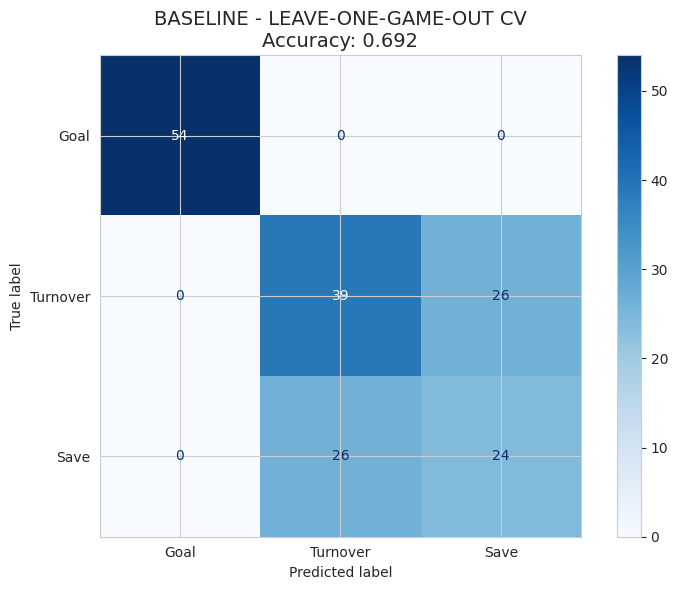


BASELINE - GROUP K-FOLD CV
  CV method: GroupKFold
  Number of splits: 5
  Running cross-validation...

  Results:
  Accuracy:            0.6864
  F1 Score (macro):    0.6894
  F1 Score (weighted): 0.6873

Confusion Matrix:
              Predicted
              Goal  Turnover  Save
Actual Goal      54        0      0
       Turnover   0       37     28
       Save       0       25     25

Classification Report:
              precision    recall  f1-score   support

        Goal       1.00      1.00      1.00        54
    Turnover       0.60      0.57      0.58        65
        Save       0.47      0.50      0.49        50

    accuracy                           0.69       169
   macro avg       0.69      0.69      0.69       169
weighted avg       0.69      0.69      0.69       169



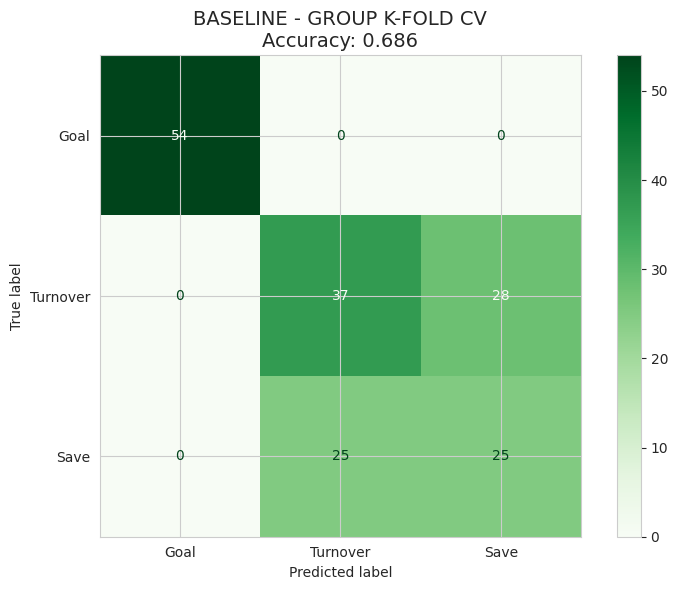


BASELINE - Feature Importance
Training model on full dataset...

✓ Model trained with 26 features

Top 10 Most Important Features:
   1. score_differential: 0.2026
   2. seconds_to_advance: 0.2285
   3. first_action_dodge: 0.2583
   4. momentum_3poss: 0.2919
   5. close_and_late: 0.3337
   6. game_state_tied: 0.3364
   7. game_state_close: 0.3749
   8. score_pressure: 0.4876
   9. poss_since_goal: 0.8813
  10. goal_streak: 1.7864


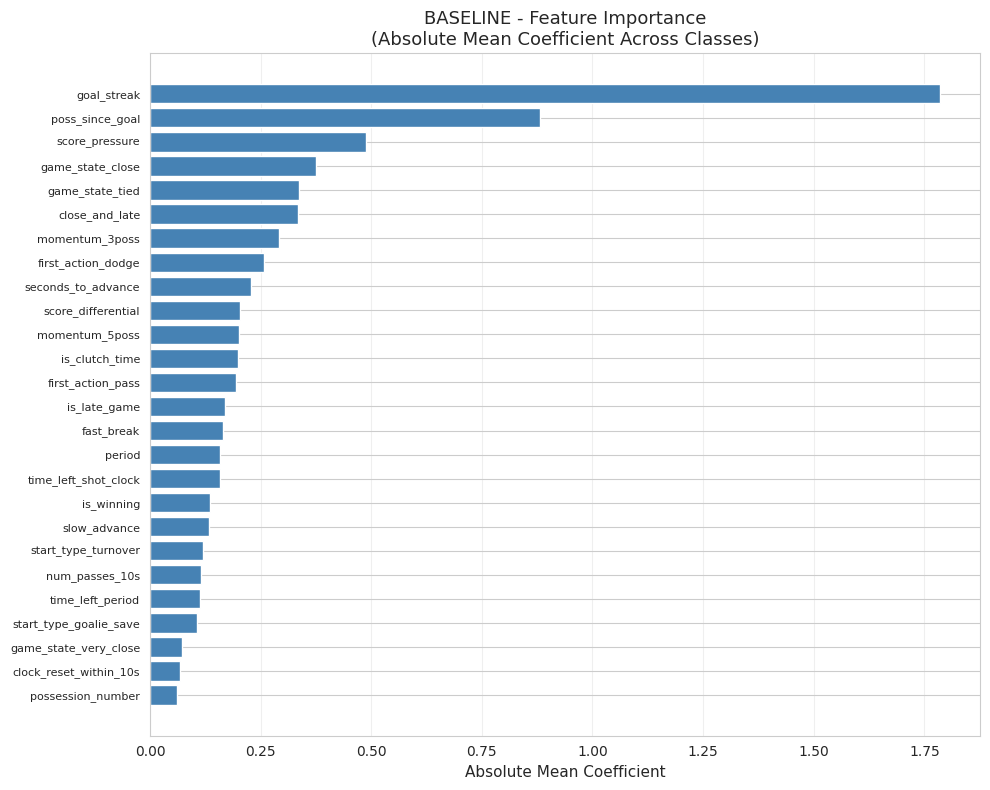

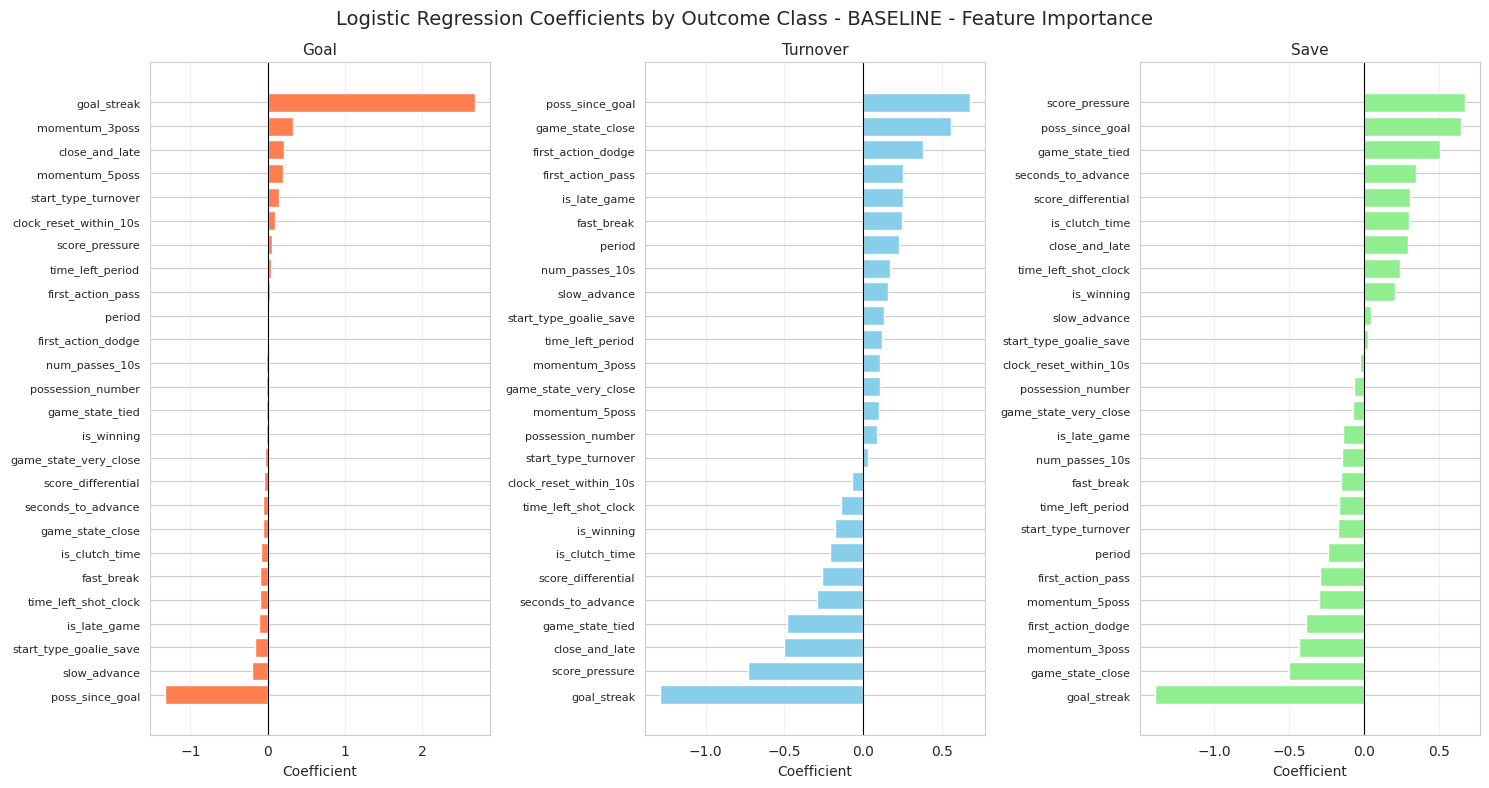


[Saving Results - baseline]
    Predictions saved to 'logistic_regression_results_baseline.csv'
    Coefficients saved to 'logistic_regression_coefficients_baseline.csv'


In [ ]:
# ==========================================================================
# BASELINE MODEL (NO LAGGED FEATURES)
# ==========================================================================
print("\n" + "="*80)
print("BASELINE MODEL - NO LAGGED FEATURES")
print("="*80)

# Create pipeline with LogisticRegression
lr_classifier = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    penalty='l2',
    C=1.0
)

lr_pipeline = create_pipeline(lr_classifier, numeric_features, categorical_features)
print(f"  Pipeline created with {len(feature_cols)} features")

# Leave-One-Game-Out CV
logo = LeaveOneGroupOut()
y_pred_logo, acc_logo, f1_logo_macro, f1_logo_weighted, cm_logo = run_cross_validation(
    lr_pipeline, X, y, groups, logo,
    "BASELINE - LEAVE-ONE-GAME-OUT CV",
    plot_cmap='Blues'
)

# GroupKFold CV
n_splits_gkf = min(5, groups.nunique())
gkf = GroupKFold(n_splits=n_splits_gkf)
y_pred_gkf, acc_gkf, f1_gkf_macro, f1_gkf_weighted, cm_gkf = run_cross_validation(
    lr_pipeline, X, y, groups, gkf,
    "BASELINE - GROUP K-FOLD CV",
    plot_cmap='Greens'
)

# Feature importance
coef_df_baseline = analyze_feature_importance_linear(lr_pipeline, X, y, "BASELINE - Feature Importance")

# Save results
baseline_results = {
    'Model': ['Baseline', 'Baseline'],
    'CV_Method': ['LOGO', 'GroupKFold'],
    'Accuracy': [acc_logo, acc_gkf],
    'F1_Macro': [f1_logo_macro, f1_gkf_macro],
    'F1_Weighted': [f1_logo_weighted, f1_gkf_weighted]
}

save_results(df, y_pred_logo, y_pred_gkf, outcome_col,
            model_suffix="baseline", results_dict=baseline_results)

# Save coefficients
coef_df_baseline.to_csv('logistic_regression_coefficients_baseline.csv')
print("    Coefficients saved to 'logistic_regression_coefficients_baseline.csv'")


LAGGED FEATURES MODEL (ORIGINAL FEATURES ONLY)

[Creating Lagged Features - ORIGINAL FEATURES ONLY]
   Created lag_period
   Created lag_time_left_period
   Created lag_time_left_shot_clock
   Created lag_score_differential
   Created lag_fast_break
   Created lag_clock_reset_within_10s
   Created lag_num_passes_10s
   Created lag_first_action
   Created lag_start_type
    Created lag_outcome

   Created 10 lagged features (from ORIGINAL features only)
    Dropped 6 first possessions
    Final: 163 possessions
    Note: Engineered features preserved but NOT lagged

  Lagged data prepared:
  X shape: (163, 32)
  Feature breakdown:
    - Original features: 10
    - Engineered features: 12
    - Lagged original features: 10
    - TOTAL: 32

  Pipeline created with 32 features

LAGGED MODEL - LEAVE-ONE-GAME-OUT CV
  CV method: LeaveOneGroupOut
  Number of splits: 6
  Running cross-validation...

  Results:
  Accuracy:            0.7485
  F1 Score (macro):    0.7432
  F1 Score (weighted): 

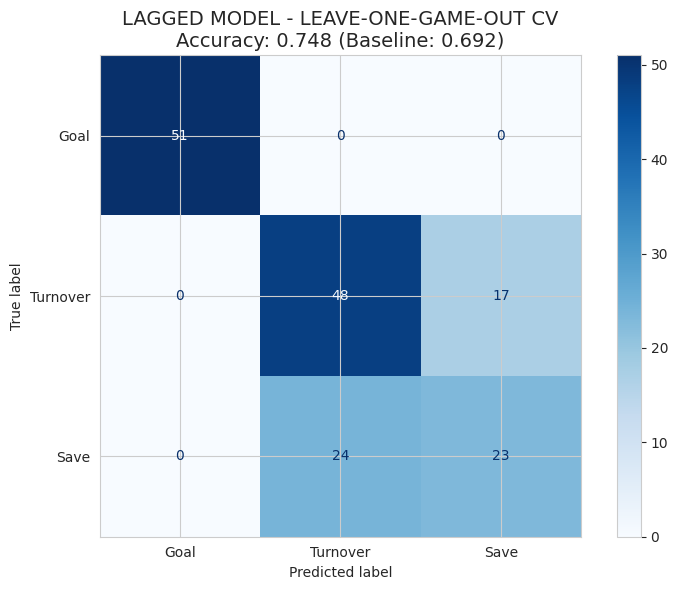


LAGGED MODEL - GROUP K-FOLD CV
  CV method: GroupKFold
  Number of splits: 5
  Running cross-validation...

  Results:
  Accuracy:            0.7485
  F1 Score (macro):    0.7420
  F1 Score (weighted): 0.7435

 Comparison to Baseline:
  Accuracy:   0.6864 → 0.7485 (Δ +0.0621)
  F1 (macro): 0.6894 → 0.7420 (Δ +0.0526)

Confusion Matrix:
              Predicted
              Goal  Turnover  Save
Actual Goal      51        0      0
       Turnover   1       48     16
       Save       0       24     23

Classification Report:
              precision    recall  f1-score   support

        Goal       0.98      1.00      0.99        51
    Turnover       0.67      0.74      0.70        65
        Save       0.59      0.49      0.53        47

    accuracy                           0.75       163
   macro avg       0.75      0.74      0.74       163
weighted avg       0.74      0.75      0.74       163



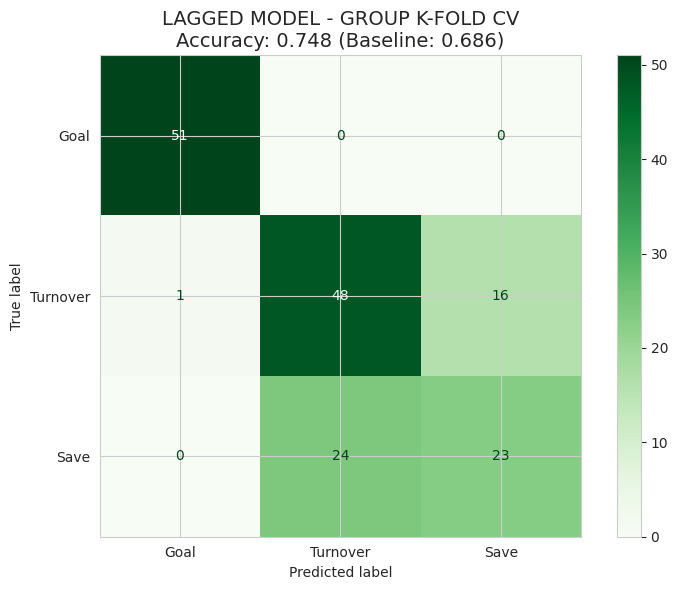


LAGGED MODEL - Feature Importance
Training model on full dataset...

✓ Model trained with 39 features

Top 10 Most Important Features:
   1. lag_first_action_pass: 0.2847
   2. fast_break: 0.3053
   3. game_state_close: 0.3816
   4. close_and_late: 0.4163
   5. score_pressure: 0.5654
   6. momentum_3poss: 0.5703
   7. lag_outcome_Save: 0.6020
   8. poss_since_goal: 0.8610
   9. lag_outcome_Turnover: 1.0585
  10. goal_streak: 1.6387


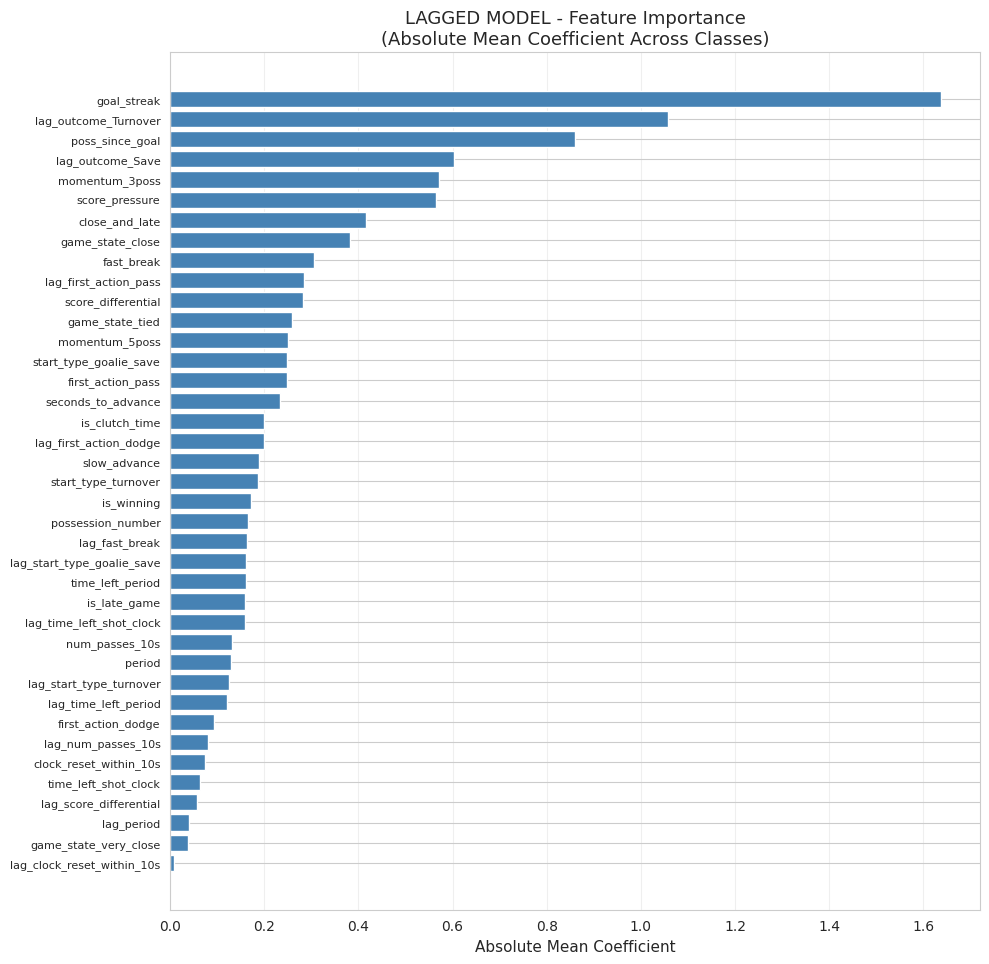

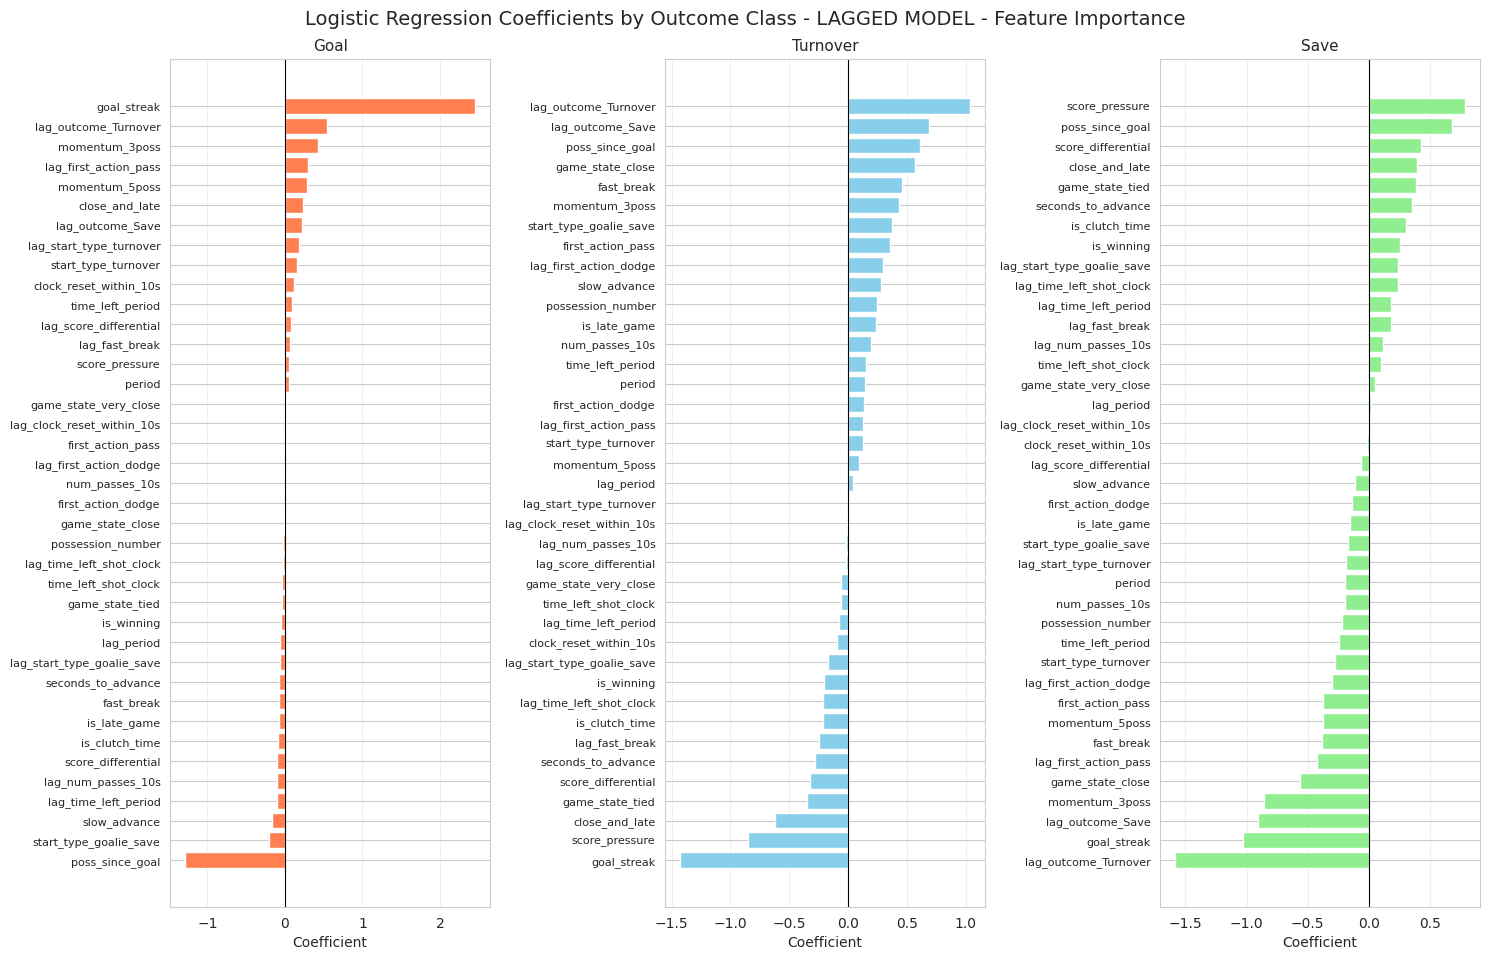


[Saving Results - lagged]
    Predictions saved to 'logistic_regression_results_lagged.csv'
  ✓ Coefficients saved to 'logistic_regression_coefficients_lagged.csv'


In [ ]:
# ==========================================================================
# LAGGED FEATURES MODEL (ORIGINAL FEATURES ONLY)
# ==========================================================================
print("\n" + "="*80)
print("LAGGED FEATURES MODEL (ORIGINAL FEATURES ONLY)")
print("="*80)

# Create lagged dataset - using ORIGINAL column map (not engineered)
df_lagged, lagged_cols, lag_numeric_features, lag_categorical_features = create_lagged_features(
    df_eng,  # Use engineered dataframe (keeps current engineered features)
    COLUMN_MAP,  # Use ORIGINAL column map (only lag original features)
    outcome_col
)

# Prepare lagged data
# Combine: original features + engineered features + lagged original features
feature_cols_lagged = feature_cols + lagged_cols
numeric_features_lagged = numeric_features + lag_numeric_features
categorical_features_lagged = categorical_features + lag_categorical_features

X_lagged = df_lagged[feature_cols_lagged].copy()
y_lagged = df_lagged[outcome_col].copy()
groups_lagged = df_lagged['game_id'].copy()

print(f"\n  Lagged data prepared:")
print(f"  X shape: {X_lagged.shape}")
print(f"  Feature breakdown:")
print(f"    - Original features: {len(COLUMN_MAP['numeric']) + len(COLUMN_MAP['categorical'])}")
print(f"    - Engineered features: {len(new_numeric) + len(new_categorical)}")
print(f"    - Lagged original features: {len(lagged_cols)}")
print(f"    - TOTAL: {len(feature_cols_lagged)}")

# Create pipeline with LogisticRegression
lr_classifier_lagged = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    penalty='l2',
    C=1.0
)

lr_pipeline_lagged = create_pipeline(lr_classifier_lagged, numeric_features_lagged, categorical_features_lagged)
print(f"\n  Pipeline created with {len(feature_cols_lagged)} features")

# Leave-One-Game-Out CV
logo_lagged = LeaveOneGroupOut()
baseline_metrics_logo = (acc_logo, f1_logo_macro, f1_logo_weighted)

y_pred_logo_lagged, acc_logo_lagged, f1_logo_lagged_macro, f1_logo_lagged_weighted, cm_logo_lagged = run_cross_validation(
    lr_pipeline_lagged, X_lagged, y_lagged, groups_lagged, logo_lagged,
    "LAGGED MODEL - LEAVE-ONE-GAME-OUT CV",
    baseline_metrics=baseline_metrics_logo,
    plot_cmap='Blues'
)

# GroupKFold CV
n_splits_gkf_lagged = min(5, groups_lagged.nunique())
gkf_lagged = GroupKFold(n_splits=n_splits_gkf_lagged)
baseline_metrics_gkf = (acc_gkf, f1_gkf_macro, f1_gkf_weighted)

y_pred_gkf_lagged, acc_gkf_lagged, f1_gkf_lagged_macro, f1_gkf_lagged_weighted, cm_gkf_lagged = run_cross_validation(
    lr_pipeline_lagged, X_lagged, y_lagged, groups_lagged, gkf_lagged,
    "LAGGED MODEL - GROUP K-FOLD CV",
    baseline_metrics=baseline_metrics_gkf,
    plot_cmap='Greens'
)

# Feature importance
coef_df_lagged = analyze_feature_importance_linear(lr_pipeline_lagged, X_lagged, y_lagged,
                                           "LAGGED MODEL - Feature Importance")

# Save results
lagged_results = {
    'Model': ['Lagged', 'Lagged'],
    'CV_Method': ['LOGO', 'GroupKFold'],
    'Accuracy': [acc_logo_lagged, acc_gkf_lagged],
    'F1_Macro': [f1_logo_lagged_macro, f1_gkf_lagged_macro],
    'F1_Weighted': [f1_logo_lagged_weighted, f1_gkf_lagged_weighted]
}

save_results(df_lagged, y_pred_logo_lagged, y_pred_gkf_lagged, outcome_col,
            model_suffix="lagged", results_dict=lagged_results)

# Save coefficients
coef_df_lagged.to_csv('logistic_regression_coefficients_lagged.csv')
print("  ✓ Coefficients saved to 'logistic_regression_coefficients_lagged.csv'")


FINAL COMPARISON - BASELINE VS LAGGED

   Model  CV_Method  Accuracy  F1_Macro  F1_Weighted  N_Features  N_Samples
Baseline       LOGO  0.692308  0.693333     0.692308          22        169
Baseline GroupKFold  0.686391  0.689371     0.687254          22        169
  Lagged       LOGO  0.748466  0.743155     0.744773          32        163
  Lagged GroupKFold  0.748466  0.741968     0.743508          32        163

  Comparison saved to 'logistic_regression_comparison.csv'


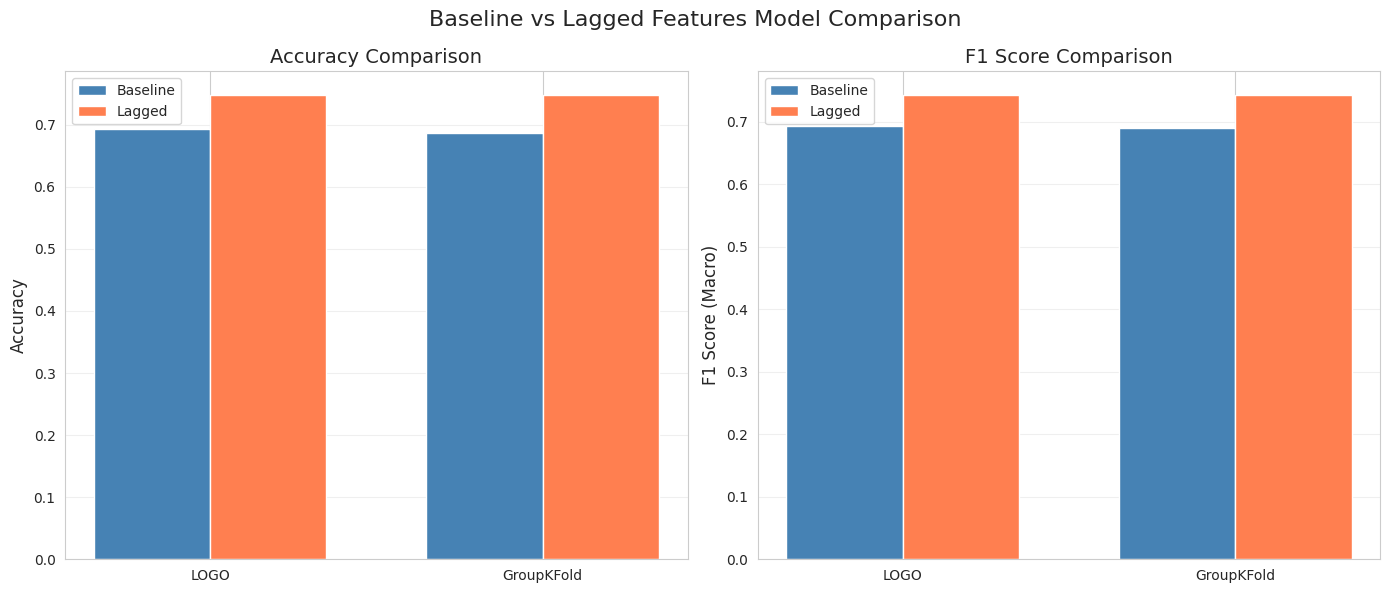


 LOGISTIC REGRESSION ANALYSIS COMPLETE


In [ ]:
# ==========================================================================
# FINAL COMPARISON
# ==========================================================================
print("\n" + "="*80)
print("FINAL COMPARISON - BASELINE VS LAGGED")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Baseline', 'Lagged', 'Lagged'],
    'CV_Method': ['LOGO', 'GroupKFold', 'LOGO', 'GroupKFold'],
    'Accuracy': [acc_logo, acc_gkf, acc_logo_lagged, acc_gkf_lagged],
    'F1_Macro': [f1_logo_macro, f1_gkf_macro, f1_logo_lagged_macro, f1_gkf_lagged_macro],
    'F1_Weighted': [f1_logo_weighted, f1_gkf_weighted, f1_logo_lagged_weighted, f1_gkf_lagged_weighted],
    'N_Features': [len(feature_cols), len(feature_cols), len(feature_cols_lagged), len(feature_cols_lagged)],
    'N_Samples': [len(df), len(df), len(df_lagged), len(df_lagged)]
})

print("\n" + comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('logistic_regression_comparison.csv', index=False)
print(f"\n  Comparison saved to 'logistic_regression_comparison.csv'")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x = np.arange(2)
width = 0.35
axes[0].bar(x - width/2, [acc_logo, acc_gkf], width, label='Baseline', color='steelblue')
axes[0].bar(x + width/2, [acc_logo_lagged, acc_gkf_lagged], width, label='Lagged', color='coral')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['LOGO', 'GroupKFold'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1 Macro comparison
axes[1].bar(x - width/2, [f1_logo_macro, f1_gkf_macro], width, label='Baseline', color='steelblue')
axes[1].bar(x + width/2, [f1_logo_lagged_macro, f1_gkf_lagged_macro], width, label='Lagged', color='coral')
axes[1].set_ylabel('F1 Score (Macro)', fontsize=12)
axes[1].set_title('F1 Score Comparison', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['LOGO', 'GroupKFold'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Baseline vs Lagged Features Model Comparison', fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(" LOGISTIC REGRESSION ANALYSIS COMPLETE")
print("="*80)